<a href="https://colab.research.google.com/github/Anjasfedo/Code-as-a-Cryptography/blob/main/ecc_lsb_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elliptic Curve Criptography

with library that use schema of ECDH + AES
1. Elliptic Curve Diffle Hellman for key exchange
2. AES to encrypt & decrypt the massage/plaintext

In [1]:
!pip install eciespy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.0 MB/s eta 0:00:00


In [2]:
CONTENT = "3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup"

In [3]:
from ecies.utils import generate_eth_key
from ecies import encrypt, decrypt

private_key = generate_eth_key()
public_key = private_key.public_key

public_key_hex = public_key.to_hex()
private_key_hex = private_key.to_hex()

print("Public Key:", public_key_hex)
print("Private Key:", private_key_hex)

ciphertext = encrypt(public_key_hex, CONTENT.encode())

print("Ciphertext:", ciphertext.hex())

decrypted_message = decrypt(private_key_hex, ciphertext)
print("Decrypted Message:", decrypted_message.decode())

Public Key: 0xda4b245451cfb02e6be9831d6e51d7ad62d2132960cf2d3957bbcbcbf758f1576841d37edcf9c1e995183577c0707d93441868c3f52ef7a4a6091e83ef6f698f
Private Key: 0xb019334351aaa4a4ed299d5a0ea40936f1af628e7c213f9fbf2614feb3d694ce
Ciphertext: 0444fed61c479cf680322ef56126a310abac59526311d46429974191144b60f6b068076c285278e2a4cb8be11d4166bb9ae05f0dd485e4b390c296c237b46fece87a47e6780bd0b59c54f752439e7c840b0e1277269a59ca1d98b27eed2676ee9167a1388ff2291722835bb556cab4a5312c083c1bfcd2434b749560cc596f55aaeca384fda3c0dc5dbfab3f184c4f81de7e94c4352733f01a244a7f1d91429c9b4bd6b35e870da4c81929f908b210d95e9e17f248d1441890bd413431ec35f4adb26de2a97061714cf1d3304e3f494278aebcf6c0b70695150d520da06f1ce81bc3687687514201f77c9d389a7172ab172674cdd87205910f8b8eddb5f71041cab63b7ee5724a0e94e7c120932584dbe136
Decrypted Message: 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup


# Koblitz Method & Elliptic Curve El Gamal

## Koblitz Method

to encode & decode integer to coordinate point on cartesius

In [4]:
# Parameters
p = 751  # prime modulus
k = 20    # chosen small integer
a = -1    # coefficient of x in the elliptic curve
b = 188    # constant in the elliptic curve

### Char to Num & Num to Char

In [5]:
# Manually create dictionaries for char-to-num and num-to-char mappings
char_to_num_dict = {
    '0': 10, '1': 11,
    'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19,
    'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27,
    'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35
}

# Reverse dictionary for num-to-char mapping
num_to_char_dict = {v: k for k, v in char_to_num_dict.items()}

# Function to map char to num
def char_to_num(char):
    if char in char_to_num_dict:
        return char_to_num_dict[char]
    else:
        raise ValueError(f"Character '{char}' is not valid. Please use '0-1' or 'a-x'.")

# Function to map num to char
def num_to_char(num):
    if num in num_to_char_dict:
        return num_to_char_dict[num]
    else:
        raise ValueError(f"Number '{num}' is not valid. Please use numbers in the range 10-35.")

def message_to_koblitz(message):
    # Convert the message to a list of characters
    chars = list(message)

    koblitz = []
    for char in chars:
        num = char_to_num(char)
        koblitz.append(num)

    return koblitz

def koblitz_to_message(koblitz):
    message = []
    for num in koblitz:
        char = num_to_char(num)
        message.append(char)

    return ''.join(message)

# Test mapping from char to num
chars = '01ax'

koblitz_message = message_to_koblitz(chars)
print("Koblitz Message:", koblitz_message)

message = koblitz_to_message(koblitz_message)
print("Message:", message)

Koblitz Message: [10, 11, 12, 35]
Message: 01ax


### Koblitz Encoding

In [6]:
import sympy as sp

# Elliptic curve equation: y^2 = x^3 + ax + b mod p
def koblitz_encode(m, max_attempts=1000):
    num = 1  # Start with x = m * k + 1
    attempts = 0

    while attempts < max_attempts:
        x = m * k + num
        rhs = (x**3 + a * x + b) % p  # right-hand side of the elliptic curve equation

        # Check if rhs is a quadratic residue modulo p
        if sp.is_quad_residue(rhs, p):
            y = sp.sqrt_mod(rhs, p)
            return (x, y)  # Return the point (x, y) as a tuple

        num += 1  # Increment to check next x value
        attempts += 1

    # If no valid point is found after max_attempts
    raise ValueError(f"No valid point found after {max_attempts} attempts for message {m}.")

def koblitz_encode_message(message):
  encoded_points = []
  for char in message:
    encoded_point = koblitz_encode(char)
    encoded_points.append(encoded_point)
    print(f"Encoded point for character '{char}': {encoded_point}")

  return encoded_points

encoded_points = koblitz_encode_message(koblitz_message)
encoded_points

Encoded point for character '10': (201, 5)
Encoded point for character '11': (224, 248)
Encoded point for character '12': (241, 230)
Encoded point for character '35': (701, 203)


[(201, 5), (224, 248), (241, 230), (701, 203)]

### Koblitz Decoding

In [7]:
# Decoding: m = (x - 1) / k
def koblitz_decode(x):
    return (x - 1) // k

def koblitz_decode_message(points):
    decoded_message = []
    for point in points:
        decoded_num = koblitz_decode(point[0])  # Decode the x-coordinate
        decoded_message.append(decoded_num)
        print(f"Decoded character for point {point}: {decoded_num}")
    return decoded_message

# Output the result
decoded_points = koblitz_decode_message(encoded_points)
decoded_points

Decoded character for point (201, 5): 10
Decoded character for point (224, 248): 11
Decoded character for point (241, 230): 12
Decoded character for point (701, 203): 35


[10, 11, 12, 35]

In [8]:
message = koblitz_to_message(decoded_points)
message

'01ax'

## Elliptic Curve El Gamal

Elliptic Curve with El Gamal

In [9]:
# Parameters
p = 11  # prime modulus
# k = 20    # chosen small integer
a = 1    # coefficient of x in the elliptic curve
b = 6    # constant in the elliptic curve
# B = (2, 4)

In [10]:
# Parameters
p = 751  # prime modulus
a = -1    # coefficient of x in the elliptic curve
b = 188    # constant in the elliptic curve

In [11]:
import random
import sympy as sp
import json
import base64

class EllipticCurveElGamal:
  def __init__(self, a, b, p, k, B=None):
    self.p = p # primer number
    self.a = a # alpha
    self.b = b # beta

    self.k = k
    self.PointB = B

    self.pointP = None
    self.pointQ = None


    self.char_to_num_dict = {
    '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
    'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17,
    'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25,
    'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33,
    'y': 34, 'z': 35, '.': 36, '#': 37, '*': 38, '/': 39, '-': 40
    }

    self.num_to_char_dict = {v: k for k, v in self.char_to_num_dict.items()}

    self.k_koblitz = max(self.char_to_num_dict.values()) + 1  # max 24 for 35 char

  def example_function(self):
      print(f"Using persistent k value: {self.k}")

  def elliptic_curve_equation(self, x):
    return (x**3 + self.a*x + self.b) % self.p

  def is_on_curve(self, x, y):
    return self.elliptic_curve_equation(x)  == (y**2) % p

  # def generate_random_number(self):
  #   self.k = random.randint(1, self.p - 1)
  #   return self.k

  def generate_random_point(self):
    while True:
      x = random.randint(1, self.p - 1)
      y = random.randint(1, self.p - 1)
      if self.is_on_curve(x, y):
        return (x, y)

  def mod_inverse(self, a, p):
      if a == 0:
          raise ValueError("Inverse does not exist for 0.")
      return pow(a, p - 2, p)

  def calculate_slope_mod(self, P, Q):
    x1, y1 = P
    x2, y2 = Q
    if x1 == x2 and y1 == y2:
        # Use the formula for point doubling when P == Q
        numerator = (3 * x1**2 + self.a) % self.p
        denominator = (2 * y1) % self.p
    else:
        # Use the formula for regular slope when P != Q
        numerator = (y2 - y1) % self.p
        denominator = (x2 - x1) % self.p

    if denominator == 0:
        raise ValueError("Slope is undefined (denominator is zero).")

    # Compute the slope as (numerator / denominator) % p, which is
    # numerator * mod_inverse(denominator, p) % p
    slope = (numerator * self.mod_inverse(denominator, self.p)) % self.p
    return slope

  def calculate_add_xr_mod(self, P, Q, m):
    x1, y1 = P
    x2, y2 = Q
    xr = (m**2 - x1 - x2) % self.p
    return xr

  def calculate_add_yr_mod(self, P, Q, m, xr):
    x1, y1 = P
    x2, y2 = Q
    yr = (m * (x1 - xr) - y1) % self.p
    return yr

  def calculate_point_addition(self, P, Q):
    m = self.calculate_slope_mod(P, Q)

    xr = self.calculate_add_xr_mod(P, Q, m)

    yr = self.calculate_add_yr_mod(P, Q, m, xr)

    R = (xr, yr)

    return R

  def calculate_dob_xr_mod(self, P, Q, m):
    x1, y1 = P
    x2, y2 = Q
    xr = (m**2 - (2 * x1)) % self.p
    return xr

  def calculate_dob_yr_mod(self, P, Q, m, xr):
    x1, y1 = P
    yr = (m * (x1 - xr) - y1) % self.p
    return yr

  def calculate_point_doubling(self, P):

    m = self.calculate_slope_mod(P, P)

    xr = self.calculate_dob_xr_mod(P, P, m)

    yr = self.calculate_dob_yr_mod(P, P, m, xr)

    R = (xr, yr)

    return R

  def calculate_point_multiplication(self, P, k):
    if k == 0:
      return None
    elif k == 1:
      return P

    # Initialize R to be the point at infinity, often represented as None in this context
    R = None
    Q = P  # Start with Q as P

    # Double-and-add method
    while k > 0:
        if k % 2 == 1:  # If k is odd, add Q to the result
            if R is None:
                R = Q  # R is the point at infinity initially
            else:
                R = self.calculate_point_addition(R, Q)
        Q = self.calculate_point_addition(Q, Q)  # Double the point Q
        k //= 2  # Move to the next bit

    return R

  def calculate_point_subtract(self, P, Q):
    # Find the inverse of point Q (x_Q, y_Q) -> (x_Q, -y_Q mod p)
    Q_inv = (Q[0], (-Q[1]) % self.p)

    # Subtract P - Q by adding P and Q_inv
    R = self.calculate_point_addition(P, Q_inv)

    return R

  def generate_public_key(self, B, private_key):
    public_key = self.calculate_point_multiplication(B, private_key)
    return public_key

  def enryption(self, M, public_key):
    # k = random.randint(1, self.p - 1) # 1 < k < p - 1

    C1 = self.calculate_point_multiplication(self.PointB, self.k)
    C2 = self.calculate_point_addition(M, self.calculate_point_multiplication(public_key, self.k))

    return (C1, C2)

  def decryption(self, C, private_key):
    C1, C2 = C

    _p = self.calculate_point_multiplication(C1, private_key)

    plain = self.calculate_point_subtract(C2, _p)

    return plain

  # Function to map char to num
  def char_to_num(self, char):
      # Ensure the input is a string; if not, convert it
      char = str(char)

      # Check if the string exists in the dictionary
      if char in self.char_to_num_dict:
          return self.char_to_num_dict[char]
      else:
          # Handle the expanded character set (0-40)
          raise ValueError(f"Character '{char}' is not valid. Please use '0-9', 'a-z', or other valid characters.")


  # Function to map num to char
  def num_to_char(self, num):
      # Ensure that the input is an integer; if it's a string digit, convert to integer
      if isinstance(num, str) and num.isdigit():
          num = int(num)

      # Now we expect num to be an integer
      if isinstance(num, int):
          if num in self.num_to_char_dict:  # Handle numbers 0-40 by converting them using the dictionary
              return self.num_to_char_dict[num]
          else:
              raise ValueError(f"Number '{num}' is out of the valid range (0-40).")
      else:
          raise ValueError(f"Input '{num}' is not valid. Please provide a valid number.")


  def message_to_koblitz(self, message):
      # Convert the message to a list of characters
      chars = list(message)

      koblitz = []
      for char in chars:
          num = self.char_to_num(char)
          koblitz.append(num)

      return koblitz

  def koblitz_to_message(self, koblitz):
      message = []
      for num in koblitz:
          char = self.num_to_char(num)
          message.append(char)

      return ''.join(message)

  def koblitz_encode(self, m, max_attempts=1000):
    num = 1  # Start with x = m * k + 1
    attempts = 0

    while attempts < max_attempts:
        x = m * self.k_koblitz + num
        rhs = (x**3 + self.a * x + self.b) % self.p  # right-hand side of the elliptic curve equation

        # Check if rhs is a quadratic residue modulo p
        if sp.is_quad_residue(rhs, self.p):
            y = sp.sqrt_mod(rhs, self.p)
            return (x, y)  # Return the point (x, y) as a tuple

        num += 1  # Increment to check next x value
        attempts += 1

    # If no valid point is found after max_attempts
    raise ValueError(f"No valid point found after {max_attempts} attempts for message {m}.")

  def koblitz_encode_message(self, message):
    encoded_points = []
    for char in message:
      encoded_point = self.koblitz_encode(char)
      encoded_points.append(encoded_point)
      # print(f"Encoded point for character '{char}': {encoded_point}")

    return encoded_points

  def koblitz_decode(self, x):
    return (x - 1) // self.k_koblitz

  def koblitz_decode_message(self, points):
      decoded_message = []
      for point in points:
          decoded_num = self.koblitz_decode(point[0])  # Decode the x-coordinate
          decoded_message.append(decoded_num)
          # print(f"Decoded character for point {point}: {decoded_num}")
      return decoded_message

  def encrypt_message(self, message, public_key):
      # Encode the message into Koblitz points
      koblitz_message = self.message_to_koblitz(message)
      encoded_message = self.koblitz_encode_message(koblitz_message)
      encrypted_points = []

      # Encrypt each Koblitz point
      for point in encoded_message:
          encrypted_point = self.enryption(point, public_key)
          encrypted_points.append(encrypted_point)

      # Convert encrypted_points (a list of tuples) to a JSON string
      encrypted_message_string = json.dumps(encrypted_points)

      # Optionally, encode the string to base64 for a cleaner ciphertext
      encrypted_message_base64 = base64.b64encode(encrypted_message_string.encode()).decode()

      return encrypted_message_base64, encrypted_points  # Return as readable string

  def decrypt_message(self, encrypted_message_base64, private_key):
      # Decode the base64 string back to the JSON string
      encrypted_message_string = base64.b64decode(encrypted_message_base64).decode()

      # Convert the JSON string back to a list of encrypted points (tuples)
      encrypted_points = json.loads(encrypted_message_string)

      decrypted_message = []

      # Decrypt each point
      for point in encrypted_points:
          decrypted_point = self.decryption(point, private_key)
          decrypted_message.append(decrypted_point)

      # Decode the Koblitz points into the original numeric values
      decoded_koblitz_points = self.koblitz_decode_message(decrypted_message)

      # Convert numeric Koblitz points to characters using num_to_char
      plain_text_message = ''.join([self.num_to_char(num) for num in decoded_koblitz_points])

      return plain_text_message

In [12]:
random_num = random.randint(1, p - 1)
print(f'random number: {random_num}')

elliptic1 = EllipticCurveElGamal(a, b, p, random_num)

# k = elliptic1.generate_random_number()
# print(f'k: {k}')

basis = elliptic1.generate_random_point()
print(f'basis: {basis}')

elliptic1.PointB = basis

print(f'is basis on curve: {elliptic1.is_on_curve(basis[0], basis[1])}')

random number: 75
basis: (103, 180)
is basis on curve: True


In [13]:
private_key = random.randint(1, p - 1)
public_key = elliptic1.generate_public_key(basis, private_key)

print(f'private key: {private_key}')
print(f'public key: {public_key}')

private key: 132
public key: (650, 693)


In [14]:
message = (385, 423)

cipher = elliptic1.enryption(message, public_key)

decrypted_message = elliptic1.decryption(cipher, private_key)

print(f'message: {message}')
print(f'cipher: {cipher}')
print(f'decrypted message: {decrypted_message}')

message: (385, 423)
cipher: ((658, 57), (635, 509))
decrypted message: (385, 423)


In [15]:
CONTENT = "3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup"

In [16]:
elliptic1.k_koblitz = 18 # max 18 if add "-#./*"

# plaintexts = "-#./*"
plaintexts = "lorem.#-/*"
# plaintexts = CONTENT
print(f'Plaintext: {plaintexts}')

ciphertexts, points_cipher = elliptic1.encrypt_message(plaintexts, public_key)
print(f'Ciphertext: {ciphertexts}')

decrypted_message = elliptic1.decrypt_message(ciphertexts, private_key)
print(f'Decryptedtext: {decrypted_message}')

Plaintext: lorem.#-/*
Ciphertext: W1tbNjU4LCA1N10sIFs0MDIsIDcyMl1dLCBbWzY1OCwgNTddLCBbMjU0LCAyNDddXSwgW1s2NTgsIDU3XSwgWzQzMiwgNDQxXV0sIFtbNjU4LCA1N10sIFsxNzMsIDcxOF1dLCBbWzY1OCwgNTddLCBbMTU5LCAxMjRdXSwgW1s2NTgsIDU3XSwgWzIzOCwgNTVdXSwgW1s2NTgsIDU3XSwgWzIwNywgNTM2XV0sIFtbNjU4LCA1N10sIFsxOTAsIDU1NV1dLCBbWzY1OCwgNTddLCBbNjQ2LCAxNjJdXSwgW1s2NTgsIDU3XSwgWzY2NiwgNjY2XV1d
Decryptedtext: lorem.#-/*


In [17]:
points_cipher

[((658, 57), (402, 722)),
 ((658, 57), (254, 247)),
 ((658, 57), (432, 441)),
 ((658, 57), (173, 718)),
 ((658, 57), (159, 124)),
 ((658, 57), (238, 55)),
 ((658, 57), (207, 536)),
 ((658, 57), (190, 555)),
 ((658, 57), (646, 162)),
 ((658, 57), (666, 666))]

In [18]:
decrypted_message == CONTENT

False

In [19]:
len(ciphertexts)

332

# Least Significant Bit

In [20]:
!git clone https://github.com/RobinDavid/LSB-Steganography && cd LSB-Steganography && ls && pip install -r requirements.txt

Cloning into 'LSB-Steganography'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 75 (delta 1), reused 2 (delta 0), pack-reused 68 (from 1)
Receiving objects: 100% (75/75), 19.72 KiB | 2.46 MiB/s, done.
Resolving deltas: 100% (26/26), done.
LICENCE  LSBSteg.py  README.md	requirements.txt
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=86ad42c5d4f9d5d361e26751117588ef508f9435f219fdee05f2beaa887998ef
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [21]:
#!/usr/bin/env python
# coding:UTF-8
"""LSBSteg.py

Usage:
  LSBSteg.py encode -i <input> -o <output> -f <file>
  LSBSteg.py decode -i <input> -o <output>

Options:
  -h, --help                Show this help
  --version                 Show the version
  -f,--file=<file>          File to hide
  -i,--in=<input>           Input image (carrier)
  -o,--out=<output>         Output image (or extracted file)
"""

import cv2
import docopt
import numpy as np


class SteganographyException(Exception):
    pass


class LSBSteg():
    def __init__(self, im):
        self.image = im
        self.height, self.width, self.nbchannels = im.shape
        self.size = self.width * self.height

        self.maskONEValues = [1,2,4,8,16,32,64,128]
        #Mask used to put one ex:1->00000001, 2->00000010 .. associated with OR bitwise
        self.maskONE = self.maskONEValues.pop(0) #Will be used to do bitwise operations

        self.maskZEROValues = [254,253,251,247,239,223,191,127]
        #Mak used to put zero ex:254->11111110, 253->11111101 .. associated with AND bitwise
        self.maskZERO = self.maskZEROValues.pop(0)

        self.curwidth = 0  # Current width position
        self.curheight = 0 # Current height position
        self.curchan = 0   # Current channel position

    def put_binary_value(self, bits): #Put the bits in the image
        for c in bits:
            val = list(self.image[self.curheight,self.curwidth]) #Get the pixel value as a list
            if int(c) == 1:
                val[self.curchan] = int(val[self.curchan]) | self.maskONE #OR with maskONE
            else:
                val[self.curchan] = int(val[self.curchan]) & self.maskZERO #AND with maskZERO

            self.image[self.curheight,self.curwidth] = tuple(val)
            self.next_slot() #Move "cursor" to the next space

    def next_slot(self):#Move to the next slot were information can be taken or put
        if self.curchan == self.nbchannels-1: #Next Space is the following channel
            self.curchan = 0
            if self.curwidth == self.width-1: #Or the first channel of the next pixel of the same line
                self.curwidth = 0
                if self.curheight == self.height-1:#Or the first channel of the first pixel of the next line
                    self.curheight = 0
                    if self.maskONE == 128: #Mask 1000000, so the last mask
                        raise SteganographyException("No available slot remaining (image filled)")
                    else: #Or instead of using the first bit start using the second and so on..
                        self.maskONE = self.maskONEValues.pop(0)
                        self.maskZERO = self.maskZEROValues.pop(0)
                else:
                    self.curheight +=1
            else:
                self.curwidth +=1
        else:
            self.curchan +=1

    def read_bit(self): #Read a single bit int the image
        val = self.image[self.curheight,self.curwidth][self.curchan]
        val = int(val) & self.maskONE
        self.next_slot()
        if val > 0:
            return "1"
        else:
            return "0"

    def read_byte(self):
        return self.read_bits(8)

    def read_bits(self, nb): #Read the given number of bits
        bits = ""
        for i in range(nb):
            bits += self.read_bit()
        return bits

    def byteValue(self, val):
        return self.binary_value(val, 8)

    def binary_value(self, val, bitsize): #Return the binary value of an int as a byte
        binval = bin(val)[2:]
        if len(binval) > bitsize:
            raise SteganographyException("binary value larger than the expected size")
        while len(binval) < bitsize:
            binval = "0"+binval
        return binval

    def encode_text(self, txt):
        l = len(txt)
        binl = self.binary_value(l, 16) #Length coded on 2 bytes so the text size can be up to 65536 bytes long
        self.put_binary_value(binl) #Put text length coded on 4 bytes
        for char in txt: #And put all the chars
            c = ord(char)
            self.put_binary_value(self.byteValue(c))
        return self.image

    def decode_text(self):
        ls = self.read_bits(16) #Read the text size in bytes
        l = int(ls,2)
        i = 0
        unhideTxt = ""
        while i < l: #Read all bytes of the text
            tmp = self.read_byte() #So one byte
            i += 1
            unhideTxt += chr(int(tmp,2)) #Every chars concatenated to str
        return unhideTxt

    def encode_image(self, imtohide):
        w = imtohide.width
        h = imtohide.height
        if self.width*self.height*self.nbchannels < w*h*imtohide.channels:
            raise SteganographyException("Carrier image not big enough to hold all the datas to steganography")
        binw = self.binary_value(w, 16) #Width coded on to byte so width up to 65536
        binh = self.binary_value(h, 16)
        self.put_binary_value(binw) #Put width
        self.put_binary_value(binh) #Put height
        for h in range(imtohide.height): #Iterate the hole image to put every pixel values
            for w in range(imtohide.width):
                for chan in range(imtohide.channels):
                    val = imtohide[h,w][chan]
                    self.put_binary_value(self.byteValue(int(val)))
        return self.image


    def decode_image(self):
        width = int(self.read_bits(16),2) #Read 16bits and convert it in int
        height = int(self.read_bits(16),2)
        unhideimg = np.zeros((width,height, 3), np.uint8) #Create an image in which we will put all the pixels read
        for h in range(height):
            for w in range(width):
                for chan in range(unhideimg.channels):
                    val = list(unhideimg[h,w])
                    val[chan] = int(self.read_byte(),2) #Read the value
                    unhideimg[h,w] = tuple(val)
        return unhideimg

    def encode_binary(self, data):
        l = len(data)
        if self.width*self.height*self.nbchannels < l+64:
            raise SteganographyException("Carrier image not big enough to hold all the datas to steganography")
        self.put_binary_value(self.binary_value(l, 64))
        for byte in data:
            byte = byte if isinstance(byte, int) else ord(byte) # Compat py2/py3
            self.put_binary_value(self.byteValue(byte))
        return self.image

    def decode_binary(self):
        l = int(self.read_bits(64), 2)
        output = b""
        for i in range(l):
            output += bytearray([int(self.read_byte(),2)])
        return output


def main():
    args = docopt.docopt(__doc__, version="0.2")
    in_f = args["--in"]
    out_f = args["--out"]
    in_img = cv2.imread(in_f)
    steg = LSBSteg(in_img)
    lossy_formats = ["jpeg", "jpg"]

    if args['encode']:
        #Handling lossy format
        out_f, out_ext = out_f.split(".")
        if out_ext in lossy_formats:
            out_f = out_f + ".png"
            print("Output file changed to ", out_f)

        data = open(args["--file"], "rb").read()
        res = steg.encode_binary(data)
        cv2.imwrite(out_f, res)

    elif args["decode"]:
        raw = steg.decode_binary()
        with open(out_f, "wb") as f:
            f.write(raw)

# if __name__=="__main__":
#     main()

# Lampel Ziv Welch

In [22]:
!git clone https://github.com/joeatwork/python-lzw

Cloning into 'python-lzw'...
remote: Enumerating objects: 80, done.
remote: Total 80 (delta 0), reused 0 (delta 0), pack-reused 80 (from 1)
Receiving objects: 100% (80/80), 3.22 MiB | 8.62 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [23]:
!cd /content/python-lzw && mv lzw/ /content/ && python setup.py install

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https

In [24]:
import lzw

# Example text to compress (can be any string)
original_text = CONTENT

# Convert the original text into bytes (UTF-8 encoding)
original_bytes = original_text.encode('utf-8')

# Part 1: Compression (in-memory)
compressed = lzw.compress(original_bytes)

# Convert compressed generator to a list to see its contents
compressed_list = list(compressed)

# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(compressed_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

# Print each variable
print("Original Text (String):", original_text)
print("Original Bytes:", original_bytes)
print("Compressed List (Byte Chunks):", compressed_list)
print("Decompressed Bytes:", decompressed_bytes)
print("Decompressed Text (String):", decompressed_text)

# Part 3: Print sizes and results for comparison
original_size = len(original_bytes)
compressed_size = len(b"".join(compressed_list))  # Join to get compressed byte size
decompressed_size = len(decompressed_bytes)

# Print the sizes in bytes
print(f"\nOriginal size: {original_size} bytes")
print(f"Compressed size: {compressed_size} bytes")
print(f"Decompressed size: {decompressed_size} bytes")

# Check if decompression was successful
if decompressed_text == original_text:
    print("Decompression was successful!")
else:
    print("Decompression failed.")

Original Text (String): 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup
Original Bytes: b'3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup'
Compressed List (Byte Chunks): [b'\x19', b'\x8c', b'\xc6', b'\x83', b'\x81', b'\xb0', b'\xc4', b'`', b'4', b'\x18', b'\x0c', b'G', b'#', b'q', b'\x84', b'8', b'j', b'#', b'1', b'\x9a', b'\x0e', b'F', b'\x93', b'\x99', b'\xd0', b'\xde', b'f', b'2', b'\x9c', b'\x85', b'F', b'H', b'\xd1', b'\xa4', b'\xc2', b'n', b'\x15', b'\x18', b'\x8e', b'\xa6', b'H', b'\xf9', b'\xba', b'.', b'#', b':', b'\x19', b'L', b'\xe6', b'\x13', b'`', b'\x8e', b'\x17', b'\x0c', b'\x16', b'\x8c', b'\x06', b's', b'!', b'\xa0', b'\x8c', b'\xd8', b'a', b'5', b'\x9a', b'E', b'\xb3', b'\x89', b'\xd0', b'\x8c', b'\xc4', b'#', b'

# Huffman Encoding

In [25]:
import heapq
from collections import Counter

# Class for Huffman Tree Nodes
class HuffmanNode:
    def __init__(self, char=None, freq=0, left=None, right=None):
        self.char = char
        self.freq = freq
        self.left = left
        self.right = right

    def __lt__(self, other):
        return self.freq < other.freq

# Function to build the Huffman Tree
def build_huffman_tree(frequency):
    heap = [HuffmanNode(char, freq) for char, freq in frequency.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(freq=node1.freq + node2.freq, left=node1, right=node2)
        heapq.heappush(heap, merged)

    return heap[0]  # Return the root of the tree

# Function to generate Huffman codes from the Huffman Tree
def generate_huffman_codes(node, current_code="", huffman_codes={}):
    if node is None:
        return

    if node.char is not None:
        huffman_codes[node.char] = current_code

    generate_huffman_codes(node.left, current_code + "0", huffman_codes)
    generate_huffman_codes(node.right, current_code + "1", huffman_codes)

    return huffman_codes

# Function to compress the data using Huffman Encoding
def huffman_compress(data):
    # Count the frequency of each byte
    frequency = Counter(data)

    # Build Huffman Tree
    huffman_tree = build_huffman_tree(frequency)

    # Generate Huffman Codes
    huffman_codes = generate_huffman_codes(huffman_tree)

    # Encode data into its binary representation
    encoded_data = "".join(huffman_codes[byte] for byte in data)

    # Pad the encoded data to make its length a multiple of 8
    padding = 8 - len(encoded_data) % 8
    encoded_data += "0" * padding
    padding_info = "{0:08b}".format(padding)

    # Convert binary data to bytes
    compressed_data = bytearray()
    compressed_data.append(int(padding_info, 2))  # First byte stores the padding information
    for i in range(0, len(encoded_data), 8):
        byte = encoded_data[i:i+8]
        compressed_data.append(int(byte, 2))

    return compressed_data, huffman_tree

# Function to decompress the data using Huffman Encoding
def huffman_decompress(compressed_data, huffman_tree):
    # Convert the compressed data to binary string
    encoded_data = ""
    for byte in compressed_data[1:]:
        encoded_data += "{0:08b}".format(byte)

    # Get the padding information from the first byte
    padding = compressed_data[0]
    encoded_data = encoded_data[:-padding]  # Remove padding

    # Traverse the Huffman tree to decode the binary string
    decoded_data = bytearray()
    node = huffman_tree
    for bit in encoded_data:
        if bit == "0":
            node = node.left
        else:
            node = node.right

        if node.left is None and node.right is None:  # Leaf node
            decoded_data.append(node.char)
            node = huffman_tree

    return decoded_data


# Example Usage of Huffman Compression/Decompression

# Step 1: The original plaintext data (as a byte string)
plaintext = CONTENT.encode()

# Print the original data
print("Original Data (as bytes):", plaintext)
print("Original Data (as string):", plaintext.decode())

# Step 2: Compress the plaintext data using Huffman encoding
compressed_data, huffman_tree = huffman_compress(plaintext)
print("Compressed Data (in bytes):", compressed_data)

# Step 3: Decompress the compressed data back to the original plaintext
decompressed_data = huffman_decompress(compressed_data, huffman_tree)
print("Decompressed Data (as bytes):", decompressed_data)
print("Decompressed Data (as string):", decompressed_data.decode())

# Step 4: Verify that the decompressed data matches the original data
if decompressed_data == plaintext:
    print("Decompression was successful!")
else:
    print("Decompression failed.")

Original Data (as bytes): b'3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup'
Original Data (as string): 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup
Compressed Data (in bytes): bytearray(b'\x02\xdfy>\xa8\x7f\x12G\xf7S\x11\x1e\xfb\xedYu\xcf\xc6)\x91\xd52\xe6\xc3\xa3usi\xf9\xd3OD;\xfb\xae\xa6\xf8\xde\xf8\x93\x80\xe1\xef\x03\x87\xed9\x90\xa2;\x10#\xf3\xe0\xdb\xca#\xbctG\xbe\x8f\xe9\xea\xa3%iQ\x9a[\xd1Wc&\xa6}\x835x\x0f\x8e\xd1\x01\xb5\x1c\x19^\xdd\xb2\x01d\xe5\x85J\x8a\xddr\x9e\x96\xcf\xcbF\xd5\xb9\x15>\xad\xd8')
Decompressed Data (as bytes): bytearray(b'3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup')

# Test Image

In [26]:
import os
# Directory where the image will be saved
ori_dir_img = "ori-image"

# Create the ori_dir_img if it doesn't exist
if not os.path.exists(ori_dir_img):
    os.makedirs(ori_dir_img)

stego_dir_img = "stego-image"

# Create the stego_dir_img if it doesn't exist
if not os.path.exists(stego_dir_img):
    os.makedirs(stego_dir_img)

## Lena Image

In [27]:
import requests
from PIL import Image
import io

# URL to the raw image file
url = "https://raw.githubusercontent.com/mikolalysenko/lena/master/lena.png"

# Download the image
response = requests.get(url)
if response.status_code == 200:
    # Load the image using PIL
    lena_image = Image.open(io.BytesIO(response.content))
    lena_image.show()  # Display the image (optional)
    lena_image.save("ori-image/lena.png")  # Save the image locally
else:
    print("Failed to download the image.")

In [28]:
LENA_IMG = 'ori-image/lena.png'

if not os.path.exists(LENA_IMG):
    raise FileNotFoundError(f"Image not found at {LENA_IMG}")

# Steganography Metric

## MSE

In [29]:
def calculate_mse(original, stego):
    return np.mean((original - stego) ** 2)

## PSNR

In [30]:
def calculate_psnr(target, ori_image=LENA_IMG):
    # Read images
    original = cv2.imread(ori_image)
    stego = cv2.imread(f'{stego_dir_img}/{target}')

    if original is None:
        raise ValueError(f"Failed to load original image from {ori_image}. Ensure the file exists and is a valid image format.")
    if stego is None:
        raise ValueError(f"Failed to load stego image from {stego_dir_img}/{target}. Ensure the file exists and is a valid image format.")

    # Calculate MSE using the separated function
    mse = calculate_mse(original, stego)
    if mse == 0:  # If images are identical
        return float('inf')

    # Calculate PSNR using the 10 log10 version
    max_pixel_value = 255.0
    psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    # print(f'PSNR: {psnr}')
    return psnr

## SSIM

In [31]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(original, stego):
    # Convert images to grayscale
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    stego_gray = cv2.cvtColor(stego, cv2.COLOR_BGR2GRAY)

    # Calculate SSIM
    ssim_value, _ = ssim(original_gray, stego_gray, full=True)
    return ssim_value

## Get it together

In [32]:
def calculate_stego_metrics(target, ori_image=LENA_IMG):
    # Read images
    original = cv2.imread(ori_image)
    stego = cv2.imread(f'{stego_dir_img}/{target}')

    if original is None:
        raise ValueError(f"Failed to load original image from {ori_image}. Ensure the file exists and is a valid image format.")
    if stego is None:
        raise ValueError(f"Failed to load stego image from {stego_dir_img}/{target}. Ensure the file exists and is a valid image format.")

    # Calculate metrics
    mse_value = calculate_mse(original, stego)
    psnr_value = calculate_psnr(target)
    ssim_value = calculate_ssim(original, stego)

    # Print results
    print(f'Metrics between original ({ori_image}) and stego image ({target}):')
    print(f'MSE: {mse_value}')
    print(f'PSNR: {psnr_value}')
    print(f'SSIM: {ssim_value}')

    return mse_value, psnr_value, ssim_value

# LSB Helper

In [33]:
def embed_lsb(target, content, ori_img = LENA_IMG):
  steg = LSBSteg(cv2.imread(ori_img))

  img_encoded = steg.encode_text(content)

  lsb_img = f"{stego_dir_img}/{target}"

  cv2.imwrite(lsb_img, img_encoded)

In [34]:
def extract_lsb(target):
  im = cv2.imread(f"{stego_dir_img}/{target}")

  steg = LSBSteg(im)

  content = steg.decode_text()

  return content

# LSB Only

In [35]:
embed_lsb("lsb_only.png", CONTENT)

In [36]:
extract_lsb("lsb_only.png")

'3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup'

In [37]:
extract_lsb("lsb_only.png") == CONTENT

True

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_image(image_file):
    """
    Load and display an image using matplotlib.

    Parameters:
    image_path (str): The path to the image file.
    """
    # Load the image
    img = mpimg.imread(f'/content/stego-image/{image_file}')

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

def display_ori_image():
    """
    Load and display an image using matplotlib.

    Parameters:
    image_path (str): The path to the image file.
    """
    # Load the image
    img = mpimg.imread(f'/content/ori-image/lena.png')

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

# Example usage
# display_image('path/to/your/image.png')

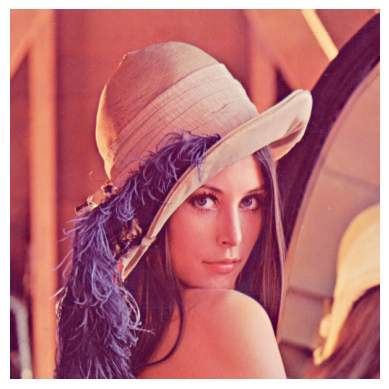

In [39]:
display_ori_image()

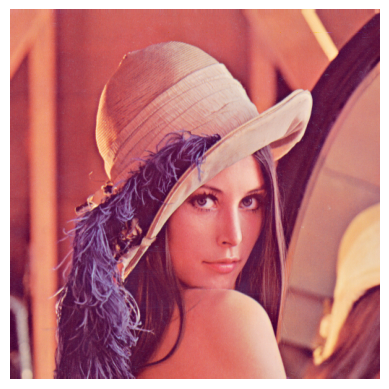

In [40]:
display_image('lsb_only.png')

## Stego Metric

In [41]:
calculate_stego_metrics("lsb_only.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_only.png):
MSE: 0.0009028116861979166
PSNR: 78.57483188820159
SSIM: 0.9999987952461553


(0.0009028116861979166, 78.57483188820159, 0.9999987952461553)

# LSB with ECC

In [42]:
ciphertext

b'\x04D\xfe\xd6\x1cG\x9c\xf6\x802.\xf5a&\xa3\x10\xab\xacYRc\x11\xd4d)\x97A\x91\x14K`\xf6\xb0h\x07l(Rx\xe2\xa4\xcb\x8b\xe1\x1dAf\xbb\x9a\xe0_\r\xd4\x85\xe4\xb3\x90\xc2\x96\xc27\xb4o\xec\xe8zG\xe6x\x0b\xd0\xb5\x9cT\xf7RC\x9e|\x84\x0b\x0e\x12w&\x9aY\xca\x1d\x98\xb2~\xed&v\xee\x91g\xa18\x8f\xf2)\x17"\x83[\xb5V\xca\xb4\xa51,\x08<\x1b\xfc\xd2CKt\x95`\xccYoU\xaa\xec\xa3\x84\xfd\xa3\xc0\xdc]\xbf\xab?\x18LO\x81\xde~\x94\xc45\'3\xf0\x1a$J\x7f\x1d\x91B\x9c\x9bK\xd6\xb3^\x87\r\xa4\xc8\x19)\xf9\x08\xb2\x10\xd9^\x9e\x17\xf2H\xd1D\x18\x90\xbdA41\xec5\xf4\xad\xb2m\xe2\xa9paqL\xf1\xd30N?IBx\xae\xbc\xf6\xc0\xb7\x06\x95\x15\rR\r\xa0o\x1c\xe8\x1b\xc3hv\x87QB\x01\xf7|\x9d8\x9aqr\xab\x17&t\xcd\xd8r\x05\x91\x0f\x8b\x8e\xdd\xb5\xf7\x10A\xca\xb6;~\xe5rJ\x0e\x94\xe7\xc1 \x93%\x84\xdb\xe16'

In [43]:
embed_lsb("lsb_w_ECC.png", ciphertext.hex())

In [44]:
embed_lsb("lsb_test.png", 'l')

In [45]:
extract_lsb("lsb_test.png")

'l'

In [46]:
calculate_stego_metrics("lsb_test.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_test.png):
MSE: 1.7801920572916668e-05
PSNR: 95.62613501860996
SSIM: 0.9999999738635894


(1.7801920572916668e-05, 95.62613501860996, 0.9999999738635894)

In [47]:
extracted_data = extract_lsb("lsb_w_ECC.png")
extracted_data

'0444fed61c479cf680322ef56126a310abac59526311d46429974191144b60f6b068076c285278e2a4cb8be11d4166bb9ae05f0dd485e4b390c296c237b46fece87a47e6780bd0b59c54f752439e7c840b0e1277269a59ca1d98b27eed2676ee9167a1388ff2291722835bb556cab4a5312c083c1bfcd2434b749560cc596f55aaeca384fda3c0dc5dbfab3f184c4f81de7e94c4352733f01a244a7f1d91429c9b4bd6b35e870da4c81929f908b210d95e9e17f248d1441890bd413431ec35f4adb26de2a97061714cf1d3304e3f494278aebcf6c0b70695150d520da06f1ce81bc3687687514201f77c9d389a7172ab172674cdd87205910f8b8eddb5f71041cab63b7ee5724a0e94e7c120932584dbe136'

In [48]:
extracted_data == ciphertext.hex()

True

In [49]:
extracted_data = bytes.fromhex(extracted_data)
extracted_data

b'\x04D\xfe\xd6\x1cG\x9c\xf6\x802.\xf5a&\xa3\x10\xab\xacYRc\x11\xd4d)\x97A\x91\x14K`\xf6\xb0h\x07l(Rx\xe2\xa4\xcb\x8b\xe1\x1dAf\xbb\x9a\xe0_\r\xd4\x85\xe4\xb3\x90\xc2\x96\xc27\xb4o\xec\xe8zG\xe6x\x0b\xd0\xb5\x9cT\xf7RC\x9e|\x84\x0b\x0e\x12w&\x9aY\xca\x1d\x98\xb2~\xed&v\xee\x91g\xa18\x8f\xf2)\x17"\x83[\xb5V\xca\xb4\xa51,\x08<\x1b\xfc\xd2CKt\x95`\xccYoU\xaa\xec\xa3\x84\xfd\xa3\xc0\xdc]\xbf\xab?\x18LO\x81\xde~\x94\xc45\'3\xf0\x1a$J\x7f\x1d\x91B\x9c\x9bK\xd6\xb3^\x87\r\xa4\xc8\x19)\xf9\x08\xb2\x10\xd9^\x9e\x17\xf2H\xd1D\x18\x90\xbdA41\xec5\xf4\xad\xb2m\xe2\xa9paqL\xf1\xd30N?IBx\xae\xbc\xf6\xc0\xb7\x06\x95\x15\rR\r\xa0o\x1c\xe8\x1b\xc3hv\x87QB\x01\xf7|\x9d8\x9aqr\xab\x17&t\xcd\xd8r\x05\x91\x0f\x8b\x8e\xdd\xb5\xf7\x10A\xca\xb6;~\xe5rJ\x0e\x94\xe7\xc1 \x93%\x84\xdb\xe16'

In [50]:
decrypted_message = decrypt(private_key_hex, extracted_data)
print("Decrypted Message:", decrypted_message.decode())

Decrypted Message: 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup


In [51]:
decrypted_message.decode() == CONTENT

True

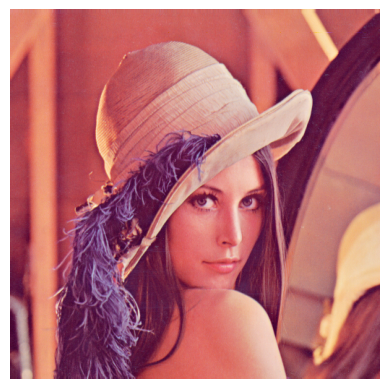

In [52]:
display_image('lsb_w_ECC.png')

## Stego Metric

In [53]:
calculate_stego_metrics("lsb_w_ECC.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_w_ECC.png):
MSE: 0.0027987162272135415
PSNR: 73.66121494985887
SSIM: 0.9999927586611943


(0.0027987162272135415, 73.66121494985887, 0.9999927586611943)

In [54]:
len(CONTENT)

177

In [55]:
len(ciphertext.hex())

548

# LSB with LZW

In [56]:
compressed_list

[b'\x19',
 b'\x8c',
 b'\xc6',
 b'\x83',
 b'\x81',
 b'\xb0',
 b'\xc4',
 b'`',
 b'4',
 b'\x18',
 b'\x0c',
 b'G',
 b'#',
 b'q',
 b'\x84',
 b'8',
 b'j',
 b'#',
 b'1',
 b'\x9a',
 b'\x0e',
 b'F',
 b'\x93',
 b'\x99',
 b'\xd0',
 b'\xde',
 b'f',
 b'2',
 b'\x9c',
 b'\x85',
 b'F',
 b'H',
 b'\xd1',
 b'\xa4',
 b'\xc2',
 b'n',
 b'\x15',
 b'\x18',
 b'\x8e',
 b'\xa6',
 b'H',
 b'\xf9',
 b'\xba',
 b'.',
 b'#',
 b':',
 b'\x19',
 b'L',
 b'\xe6',
 b'\x13',
 b'`',
 b'\x8e',
 b'\x17',
 b'\x0c',
 b'\x16',
 b'\x8c',
 b'\x06',
 b's',
 b'!',
 b'\xa0',
 b'\x8c',
 b'\xd8',
 b'a',
 b'5',
 b'\x9a',
 b'E',
 b'\xb3',
 b'\x89',
 b'\xd0',
 b'\x8c',
 b'\xc4',
 b'#',
 b'5',
 b'\x1b',
 b'\x05',
 b'\xc2',
 b'\xa3',
 b'\x84',
 b'\xb4',
 b'\xc2',
 b'*',
 b'\x19',
 b'\x0c',
 b'\x85',
 b'F',
 b'\xe3',
 b'}',
 b'\x10',
 b'f',
 b'0',
 b'\x11',
 b'\xc3',
 b'\xea',
 b'C',
 b'\x11',
 b'\xb8',
 b'\x8c',
 b'\xda',
 b'e',
 b'5',
 b'\x18',
 b'N',
 b'f',
 b'S',
 b'h',
 b'\xaa',
 b'T',
 b'n',
 b'\x96',
 b'\x1a',
 b'\x04',
 b'f',
 b'\xb3',

In [57]:
embed_lsb("lsb_w_LZW.png", compressed_list)

In [58]:
extracted_data = extract_lsb("lsb_w_LZW.png")
extracted_data

'\x19\x8cÆ\x83\x81°Ä`4\x18\x0cG#q\x848j#1\x9a\x0eF\x93\x99ÐÞf2\x9c\x85FHÑ¤Ân\x15\x18\x8e¦Hùº.#:\x19Læ\x13`\x8e\x17\x0c\x16\x8c\x06s!\xa0\x8cØa5\x9aE³\x89Ð\x8cÄ#5\x1b\x05Â£\x84´Â*\x19\x0c\x85Fã}\x10f0\x11ÃêC\x11¸\x8cÚe5\x18NfShªTn\x96\x1a\x04f³\x91\x84Úa:Y-&\x83y°Òk\x9f\x99M\x87Zñ¬Âw4\x9b\x84g\x0b\x99\x86´r\x17Ú\r\x15¸©ÜÂ#;\x9b\x8d":åÔë\x1b4\x1aL\x87S\x84\x00'

In [59]:
byte_list = [bytes([ord(char)]) for char in extracted_data]
byte_list

[b'\x19',
 b'\x8c',
 b'\xc6',
 b'\x83',
 b'\x81',
 b'\xb0',
 b'\xc4',
 b'`',
 b'4',
 b'\x18',
 b'\x0c',
 b'G',
 b'#',
 b'q',
 b'\x84',
 b'8',
 b'j',
 b'#',
 b'1',
 b'\x9a',
 b'\x0e',
 b'F',
 b'\x93',
 b'\x99',
 b'\xd0',
 b'\xde',
 b'f',
 b'2',
 b'\x9c',
 b'\x85',
 b'F',
 b'H',
 b'\xd1',
 b'\xa4',
 b'\xc2',
 b'n',
 b'\x15',
 b'\x18',
 b'\x8e',
 b'\xa6',
 b'H',
 b'\xf9',
 b'\xba',
 b'.',
 b'#',
 b':',
 b'\x19',
 b'L',
 b'\xe6',
 b'\x13',
 b'`',
 b'\x8e',
 b'\x17',
 b'\x0c',
 b'\x16',
 b'\x8c',
 b'\x06',
 b's',
 b'!',
 b'\xa0',
 b'\x8c',
 b'\xd8',
 b'a',
 b'5',
 b'\x9a',
 b'E',
 b'\xb3',
 b'\x89',
 b'\xd0',
 b'\x8c',
 b'\xc4',
 b'#',
 b'5',
 b'\x1b',
 b'\x05',
 b'\xc2',
 b'\xa3',
 b'\x84',
 b'\xb4',
 b'\xc2',
 b'*',
 b'\x19',
 b'\x0c',
 b'\x85',
 b'F',
 b'\xe3',
 b'}',
 b'\x10',
 b'f',
 b'0',
 b'\x11',
 b'\xc3',
 b'\xea',
 b'C',
 b'\x11',
 b'\xb8',
 b'\x8c',
 b'\xda',
 b'e',
 b'5',
 b'\x18',
 b'N',
 b'f',
 b'S',
 b'h',
 b'\xaa',
 b'T',
 b'n',
 b'\x96',
 b'\x1a',
 b'\x04',
 b'f',
 b'\xb3',

In [60]:
compressed_list == byte_list

True

In [61]:
# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(byte_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

print("Decompressed Text (String):", decompressed_text)

Decompressed Text (String): 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup


In [62]:
decompressed_text == CONTENT

True

## Stego Metric

In [63]:
calculate_stego_metrics("lsb_w_LZW.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_w_LZW.png):
MSE: 0.0008722941080729166
PSNR: 78.72417421832482
SSIM: 0.9999988544716335


(0.0008722941080729166, 78.72417421832482, 0.9999988544716335)

# LSB with ECC, LZW

## ECC

In [64]:
ciphertext.hex()

'0444fed61c479cf680322ef56126a310abac59526311d46429974191144b60f6b068076c285278e2a4cb8be11d4166bb9ae05f0dd485e4b390c296c237b46fece87a47e6780bd0b59c54f752439e7c840b0e1277269a59ca1d98b27eed2676ee9167a1388ff2291722835bb556cab4a5312c083c1bfcd2434b749560cc596f55aaeca384fda3c0dc5dbfab3f184c4f81de7e94c4352733f01a244a7f1d91429c9b4bd6b35e870da4c81929f908b210d95e9e17f248d1441890bd413431ec35f4adb26de2a97061714cf1d3304e3f494278aebcf6c0b70695150d520da06f1ce81bc3687687514201f77c9d389a7172ab172674cdd87205910f8b8eddb5f71041cab63b7ee5724a0e94e7c120932584dbe136'

## LZW

In [65]:
import lzw

# Example text to compress (can be any string)
original_text = ciphertext.hex()

# Convert the original text into bytes (UTF-8 encoding)
original_bytes = original_text.encode('utf-8')

# Part 1: Compression (in-memory)
compressed = lzw.compress(original_bytes)

# Convert compressed generator to a list to see its contents
compressed_list = list(compressed)

# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(compressed_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

# Print each variable
print("Original Text (String):", original_text)
print("Original Bytes:", original_bytes)
print("Compressed List (Byte Chunks):", compressed_list)
print("Decompressed Bytes:", decompressed_bytes)
print("Decompressed Text (String):", decompressed_text)

# Part 3: Print sizes and results for comparison
original_size = len(original_bytes)
compressed_size = len(b"".join(compressed_list))  # Join to get compressed byte size
decompressed_size = len(decompressed_bytes)

# Print the sizes in bytes
print(f"\nOriginal size: {original_size} bytes")
print(f"Compressed size: {compressed_size} bytes")
print(f"Decompressed size: {decompressed_size} bytes")

# Check if decompression was successful
if decompressed_text == original_text:
    print("Decompression was successful!")
else:
    print("Decompression failed.")

Original Text (String): 0444fed61c479cf680322ef56126a310abac59526311d46429974191144b60f6b068076c285278e2a4cb8be11d4166bb9ae05f0dd485e4b390c296c237b46fece87a47e6780bd0b59c54f752439e7c840b0e1277269a59ca1d98b27eed2676ee9167a1388ff2291722835bb556cab4a5312c083c1bfcd2434b749560cc596f55aaeca384fda3c0dc5dbfab3f184c4f81de7e94c4352733f01a244a7f1d91429c9b4bd6b35e870da4c81929f908b210d95e9e17f248d1441890bd413431ec35f4adb26de2a97061714cf1d3304e3f494278aebcf6c0b70695150d520da06f1ce81bc3687687514201f77c9d389a7172ab172674cdd87205910f8b8eddb5f71041cab63b7ee5724a0e94e7c120932584dbe136
Original Bytes: b'0444fed61c479cf680322ef56126a310abac59526311d46429974191144b60f6b068076c285278e2a4cb8be11d4166bb9ae05f0dd485e4b390c296c237b46fece87a47e6780bd0b59c54f752439e7c840b0e1277269a59ca1d98b27eed2676ee9167a1388ff2291722835bb556cab4a5312c083c1bfcd2434b749560cc596f55aaeca384fda3c0dc5dbfab3f184c4f81de7e94c4352733f01a244a7f1d91429c9b4bd6b35e870da4c81929f908b210d95e9e17f248d1441890bd413431ec35f4adb26de2a97061714cf1d3304

## LSB

In [66]:
compressed_list

[b'\x18',
 b'\r',
 b' ',
 b'f',
 b'c',
 b')',
 b'\x90',
 b'l',
 b'1',
 b'1',
 b'\x8d',
 b'\x06',
 b'\xe3',
 b'\x93',
 b'\x19',
 b'\x98',
 b'l',
 b'8',
 b'\x18',
 b'\x0c',
 b'\xc6',
 b'C',
 b'#',
 b')',
 b'\x98',
 b'k',
 b'\x08',
 b'\x19',
 b'\r',
 b'\x8c',
 b'#',
 b'1',
 b'\x88',
 b'\xc0',
 b'\xc2',
 b'b',
 b'0',
 b'\x98',
 b'\xc6',
 b'\xa3',
 b'\x91',
 b'\xac',
 b'j',
 b':',
 b'1',
 b'2',
 b'\r',
 b'\x06',
 b'\xc3',
 b'A',
 b'\x90',
 b'\xe4',
 b'r',
 b'7',
 b'\x1a',
 b'\x0c',
 b'G',
 b'#',
 b'\x11',
 b'\x8c',
 b'\x0c',
 b'\xc4',
 b'6',
 b'\x18',
 b'C',
 b'\xcc',
 b'C',
 b'\x08',
 b'\x80',
 b'\xc0',
 b'n',
 b'6',
 b'1',
 b'\x8c',
 b'\x87',
 b'\x12',
 b'a',
 b'\xb8',
 b'\xe0',
 b'\xca',
 b'2',
 b'0',
 b'\x8d',
 b'\x0c',
 b'f',
 b'!',
 b'\xc1',
 b'\x88',
 b'\xcb',
 b'5',
 b'\x95',
 b'\x0c',
 b'F',
 b'\xc3',
 b'c',
 b'\x11',
 b'\x88',
 b'r',
 b'a',
 b'2',
 b'\x8c',
 b'\x06',
 b'\xa6',
 b'a',
 b'\x81',
 b'\x92',
 b'U',
 b'D',
 b'2',
 b'\x8d',
 b'\x0c',
 b'C',
 b'1',
 b'\xc8',
 b'\xc2',
 b'

In [67]:
embed_lsb("lsb_w_ECC_LZW.png", compressed_list)

In [68]:
extracted_data = extract_lsb("lsb_w_ECC_LZW.png")
extracted_data

'\x18\r fc)\x90l11\x8d\x06ã\x93\x19\x98l8\x18\x0cÆC#)\x98k\x08\x19\r\x8c#1\x88ÀÂb0\x98Æ£\x91¬j:12\r\x06ÃA\x90är7\x1a\x0cG#\x11\x8c\x0cÄ6\x18CÌC\x08\x80Àn61\x8c\x87\x12a¸àÊ20\x8d\x0cf!Á\x88Ë5\x95\x0cFÃc\x11\x88ra2\x8c\x06¦a\x81\x92UD2\x8d\x0cC1ÈÂ\x849\xa0\x8c\x86cs\x14®\nc2\x8e\x06ô¡¹\x94mF\x18\x18\x8c\x97©$\x8chf\x1bÉ\x86\x96S(ÜÆ8\x1a^\x86\x15\x01\x90Üo\x1a¬_\x8c2\x91Í;\x1ce\x83F¨\x19\x99¥ã(3\x1c\x0e\x0cÆh¤Ó!C\x19\x8djÃXÁ\x8e@40\x8dc£#\x18Àp31\x8cLFc\x19\x90e\x84±Ìd³\x93\x1c\x8eÓ\x17\x1a\x98k:ý\x0e\x00É\x1cÛ\x19$fMä\x80ff\x18âaFaÄ§\x0ce\x1cÒð\x94Q\x9f``10ð6#~É\x92i-\x86\x8em×º®ªä7¯R±\x139q\x99feÑç¼5xU\x07µÀ\x0e\x06DÙ2\x0e\x16eí2\x0cØ@Äe\x18Ú¡\x99±uQ¡\x91H\x18S\x04ô1\rÓd9)y\x90!\x95Ø\r\x1e&88VF$9A^\x9f\x90Ù%\x0cCUy&~\x93×eqw¢àÍ\x10P\x170Õ6\x0c\x9e\x86\x05\x87\x0eFF\x85X\x88Y\x04\x82 fÔµ}s\x91RDyÝSPgU\\\x88P$% \r\x831\x89v\x19CVA±c\x1e&\x19º\x91C\x94L5b]UB?@\x00'

In [69]:
byte_list = [bytes([ord(char)]) for char in extracted_data]
byte_list

[b'\x18',
 b'\r',
 b' ',
 b'f',
 b'c',
 b')',
 b'\x90',
 b'l',
 b'1',
 b'1',
 b'\x8d',
 b'\x06',
 b'\xe3',
 b'\x93',
 b'\x19',
 b'\x98',
 b'l',
 b'8',
 b'\x18',
 b'\x0c',
 b'\xc6',
 b'C',
 b'#',
 b')',
 b'\x98',
 b'k',
 b'\x08',
 b'\x19',
 b'\r',
 b'\x8c',
 b'#',
 b'1',
 b'\x88',
 b'\xc0',
 b'\xc2',
 b'b',
 b'0',
 b'\x98',
 b'\xc6',
 b'\xa3',
 b'\x91',
 b'\xac',
 b'j',
 b':',
 b'1',
 b'2',
 b'\r',
 b'\x06',
 b'\xc3',
 b'A',
 b'\x90',
 b'\xe4',
 b'r',
 b'7',
 b'\x1a',
 b'\x0c',
 b'G',
 b'#',
 b'\x11',
 b'\x8c',
 b'\x0c',
 b'\xc4',
 b'6',
 b'\x18',
 b'C',
 b'\xcc',
 b'C',
 b'\x08',
 b'\x80',
 b'\xc0',
 b'n',
 b'6',
 b'1',
 b'\x8c',
 b'\x87',
 b'\x12',
 b'a',
 b'\xb8',
 b'\xe0',
 b'\xca',
 b'2',
 b'0',
 b'\x8d',
 b'\x0c',
 b'f',
 b'!',
 b'\xc1',
 b'\x88',
 b'\xcb',
 b'5',
 b'\x95',
 b'\x0c',
 b'F',
 b'\xc3',
 b'c',
 b'\x11',
 b'\x88',
 b'r',
 b'a',
 b'2',
 b'\x8c',
 b'\x06',
 b'\xa6',
 b'a',
 b'\x81',
 b'\x92',
 b'U',
 b'D',
 b'2',
 b'\x8d',
 b'\x0c',
 b'C',
 b'1',
 b'\xc8',
 b'\xc2',
 b'

In [70]:
compressed_list == byte_list

True

In [71]:
# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(byte_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

print("Decompressed Text (String):", decompressed_text)

Decompressed Text (String): 0444fed61c479cf680322ef56126a310abac59526311d46429974191144b60f6b068076c285278e2a4cb8be11d4166bb9ae05f0dd485e4b390c296c237b46fece87a47e6780bd0b59c54f752439e7c840b0e1277269a59ca1d98b27eed2676ee9167a1388ff2291722835bb556cab4a5312c083c1bfcd2434b749560cc596f55aaeca384fda3c0dc5dbfab3f184c4f81de7e94c4352733f01a244a7f1d91429c9b4bd6b35e870da4c81929f908b210d95e9e17f248d1441890bd413431ec35f4adb26de2a97061714cf1d3304e3f494278aebcf6c0b70695150d520da06f1ce81bc3687687514201f77c9d389a7172ab172674cdd87205910f8b8eddb5f71041cab63b7ee5724a0e94e7c120932584dbe136


In [72]:
decompressed_text == ciphertext.hex()

True

In [73]:
cipher_data = bytes.fromhex(decompressed_text)
cipher_data

b'\x04D\xfe\xd6\x1cG\x9c\xf6\x802.\xf5a&\xa3\x10\xab\xacYRc\x11\xd4d)\x97A\x91\x14K`\xf6\xb0h\x07l(Rx\xe2\xa4\xcb\x8b\xe1\x1dAf\xbb\x9a\xe0_\r\xd4\x85\xe4\xb3\x90\xc2\x96\xc27\xb4o\xec\xe8zG\xe6x\x0b\xd0\xb5\x9cT\xf7RC\x9e|\x84\x0b\x0e\x12w&\x9aY\xca\x1d\x98\xb2~\xed&v\xee\x91g\xa18\x8f\xf2)\x17"\x83[\xb5V\xca\xb4\xa51,\x08<\x1b\xfc\xd2CKt\x95`\xccYoU\xaa\xec\xa3\x84\xfd\xa3\xc0\xdc]\xbf\xab?\x18LO\x81\xde~\x94\xc45\'3\xf0\x1a$J\x7f\x1d\x91B\x9c\x9bK\xd6\xb3^\x87\r\xa4\xc8\x19)\xf9\x08\xb2\x10\xd9^\x9e\x17\xf2H\xd1D\x18\x90\xbdA41\xec5\xf4\xad\xb2m\xe2\xa9paqL\xf1\xd30N?IBx\xae\xbc\xf6\xc0\xb7\x06\x95\x15\rR\r\xa0o\x1c\xe8\x1b\xc3hv\x87QB\x01\xf7|\x9d8\x9aqr\xab\x17&t\xcd\xd8r\x05\x91\x0f\x8b\x8e\xdd\xb5\xf7\x10A\xca\xb6;~\xe5rJ\x0e\x94\xe7\xc1 \x93%\x84\xdb\xe16'

In [74]:
decrypted_message = decrypt(private_key_hex, cipher_data)
print("Decrypted Message:", decrypted_message.decode())

Decrypted Message: 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup


In [75]:
decrypted_message.decode() == CONTENT

True

## Stego Metric

In [76]:
calculate_stego_metrics("lsb_w_ECC_LZW.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_w_ECC_LZW.png):
MSE: 0.0022061665852864585
PSNR: 74.69442058412342
SSIM: 0.9999953890089817


(0.0022061665852864585, 74.69442058412342, 0.9999953890089817)

# LSB with Huffman

In [77]:
compressed_data

bytearray(b'\x02\xdfy>\xa8\x7f\x12G\xf7S\x11\x1e\xfb\xedYu\xcf\xc6)\x91\xd52\xe6\xc3\xa3usi\xf9\xd3OD;\xfb\xae\xa6\xf8\xde\xf8\x93\x80\xe1\xef\x03\x87\xed9\x90\xa2;\x10#\xf3\xe0\xdb\xca#\xbctG\xbe\x8f\xe9\xea\xa3%iQ\x9a[\xd1Wc&\xa6}\x835x\x0f\x8e\xd1\x01\xb5\x1c\x19^\xdd\xb2\x01d\xe5\x85J\x8a\xddr\x9e\x96\xcf\xcbF\xd5\xb9\x15>\xad\xd8')

In [78]:
compressed_data.hex()

'02df793ea87f1247f753111efbed5975cfc62991d532e6c3a3757369f9d34f443bfbaea6f8def89380e1ef0387ed3990a23b1023f3e0dbca23bc7447be8fe9eaa32569519a5bd1576326a67d8335780f8ed101b51c195eddb20164e5854a8add729e96cfcb46d5b9153eadd8'

In [79]:
embed_lsb("lsb_w_Huffman.png", compressed_data.hex())

In [80]:
extracted_data = extract_lsb("lsb_w_Huffman.png")
extracted_data

'02df793ea87f1247f753111efbed5975cfc62991d532e6c3a3757369f9d34f443bfbaea6f8def89380e1ef0387ed3990a23b1023f3e0dbca23bc7447be8fe9eaa32569519a5bd1576326a67d8335780f8ed101b51c195eddb20164e5854a8add729e96cfcb46d5b9153eadd8'

In [81]:
len(extract_lsb("lsb_w_Huffman.png"))

216

In [82]:
len(CONTENT)

177

In [83]:
huffman_data = bytearray.fromhex(extracted_data)
huffman_data

bytearray(b'\x02\xdfy>\xa8\x7f\x12G\xf7S\x11\x1e\xfb\xedYu\xcf\xc6)\x91\xd52\xe6\xc3\xa3usi\xf9\xd3OD;\xfb\xae\xa6\xf8\xde\xf8\x93\x80\xe1\xef\x03\x87\xed9\x90\xa2;\x10#\xf3\xe0\xdb\xca#\xbctG\xbe\x8f\xe9\xea\xa3%iQ\x9a[\xd1Wc&\xa6}\x835x\x0f\x8e\xd1\x01\xb5\x1c\x19^\xdd\xb2\x01d\xe5\x85J\x8a\xddr\x9e\x96\xcf\xcbF\xd5\xb9\x15>\xad\xd8')

In [84]:
decompressed_data = huffman_decompress(huffman_data, huffman_tree)
print("Decompressed Data (as bytes):", decompressed_data)
print("Decompressed Data (as string):", decompressed_data.decode())

Decompressed Data (as bytes): bytearray(b'3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup')
Decompressed Data (as string): 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup


In [85]:
decompressed_data.decode() == CONTENT

True

## Stego Metric

In [86]:
calculate_stego_metrics("lsb_w_Huffman.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_w_Huffman.png):
MSE: 0.00107574462890625
PSNR: 77.81371174500211
SSIM: 0.9999984186394683


(0.00107574462890625, 77.81371174500211, 0.9999984186394683)

# LSB with ECC, Huffman

## ECC

In [87]:
ciphertext.hex()

'0444fed61c479cf680322ef56126a310abac59526311d46429974191144b60f6b068076c285278e2a4cb8be11d4166bb9ae05f0dd485e4b390c296c237b46fece87a47e6780bd0b59c54f752439e7c840b0e1277269a59ca1d98b27eed2676ee9167a1388ff2291722835bb556cab4a5312c083c1bfcd2434b749560cc596f55aaeca384fda3c0dc5dbfab3f184c4f81de7e94c4352733f01a244a7f1d91429c9b4bd6b35e870da4c81929f908b210d95e9e17f248d1441890bd413431ec35f4adb26de2a97061714cf1d3304e3f494278aebcf6c0b70695150d520da06f1ce81bc3687687514201f77c9d389a7172ab172674cdd87205910f8b8eddb5f71041cab63b7ee5724a0e94e7c120932584dbe136'

## Huffman

In [88]:
# Example Usage of Huffman Compression/Decompression

# Step 1: The original plaintext data (as a byte string)
plaintext = ciphertext.hex().encode()

# Print the original data
print("Original Data (as bytes):", plaintext)
print("Original Data (as string):", plaintext.decode())

# Step 2: Compress the plaintext data using Huffman encoding
compressed_data, huffman_tree = huffman_compress(plaintext)
print("Compressed Data (in bytes):", compressed_data)

Original Data (as bytes): b'0444fed61c479cf680322ef56126a310abac59526311d46429974191144b60f6b068076c285278e2a4cb8be11d4166bb9ae05f0dd485e4b390c296c237b46fece87a47e6780bd0b59c54f752439e7c840b0e1277269a59ca1d98b27eed2676ee9167a1388ff2291722835bb556cab4a5312c083c1bfcd2434b749560cc596f55aaeca384fda3c0dc5dbfab3f184c4f81de7e94c4352733f01a244a7f1d91429c9b4bd6b35e870da4c81929f908b210d95e9e17f248d1441890bd413431ec35f4adb26de2a97061714cf1d3304e3f494278aebcf6c0b70695150d520da06f1ce81bc3687687514201f77c9d389a7172ab172674cdd87205910f8b8eddb5f71041cab63b7ee5724a0e94e7c120932584dbe136'
Original Data (as string): 0444fed61c479cf680322ef56126a310abac59526311d46429974191144b60f6b068076c285278e2a4cb8be11d4166bb9ae05f0dd485e4b390c296c237b46fece87a47e6780bd0b59c54f752439e7c840b0e1277269a59ca1d98b27eed2676ee9167a1388ff2291722835bb556cab4a5312c083c1bfcd2434b749560cc596f55aaeca384fda3c0dc5dbfab3f184c4f81de7e94c4352733f01a244a7f1d91429c9b4bd6b35e870da4c81929f908b210d95e9e17f248d1441890bd413431ec35f4adb26de2a97

## LSB

In [89]:
compressed_data

bytearray(b'\x08\x8f\xff\x167\xe9\xfd\xb9\x17X,\xc6\x14~\xc7\x02\xe8\n\tKLr\xee?\x7f\xcb\xbd\xfe\xbe\xef\xfax\x17\xa8u\x8dy\xc5L\xd5l\x0f\x9aZn\xe3\xfew\xaa\xb0hA\x83?To\xa2\xb8\x9c\xb7\x9c-\xafqie\xd0\xfdg\xd5\x8a8\xa4\xb9O\x1dL\xf2\xb6\xd9_\x8a\x86\xec\xdd\xc7\xb0K\x90\xe3\xb5\xac\xd6c\xc7\xd7f\xbe}\x0e%Q\x1c\xcb\xed\xccRJ\xa4G\x90\xaf\x04.\xc9\x85)\xea\x19<\xf2\xfa\xdf\xb4x\x99KqD\x00i\x02_\x13\x02\x989C\xa1\n!\xe5\xf9\xf1^6\xd6\xbf\x9f$\xcd"\x18\xe0\xcf\xf0\xd1\xe3\xbe\xfc\xb9\xba\xfa7\xa2F]\x83\x0f\x95\xeb\xcb\x1b\x85\xac\xe8;F\xb6\xed\x1c\xf5>\xff\xe5\xb8\xa3\xfe/.i$\x1f\x03\xacsl\x0b\xd8~\xde\xf9\x1e2(\xf6!\xfb\xfc\xd5\x06\xa9\x17\x98\xad\x87\xb4\xe4\x83L\x83\x08q\xe9e\xea\x92u\xd7]N\xfc\x8e\x1d\xd9\xb3%\xb0\xde\xdc\n\xed\xc7\xdf\x935\xdc\x84\xbe\x81ZV3\xa4\x1d\xe8\xfe\x90\xa7*\xd6d\xdc\xf0\x86\xbfm\x9e\xc8\xb2\xc4_:n\'\x00')

In [90]:
compressed_data.hex()

'088fff1637e9fdb917582cc6147ec702e80a094b4c72ee3f7fcbbdfebeeffa7817a8758d79c54cd56c0f9a5a6ee3fe77aab06841833f546fa2b89cb79c2daf716965d0fd67d58a38a4b94f1d4cf2b6d95f8a86ecddc7b04b90e3b5acd663c7d766be7d0e25511ccbedcc524aa44790af042ec98529ea193cf2fadfb478994b71440069025f1302983943a10a21e5f9f15e36d6bf9f24cd2218e0cff0d1e3befcb9bafa37a2465d830f95ebcb1b85ace83b46b6ed1cf53effe5b8a3fe2f2e69241f03ac736c0bd87edef91e3228f621fbfcd506a91798ad87b4e4834c830871e965ea9275d75d4efc8e1dd9b325b0dedc0aedc7df9335dc84be815a5633a41de8fe90a72ad664dcf086bf6d9ec8b2c45f3a6e2700'

In [91]:
len(compressed_data.hex())

552

In [92]:
len(ciphertext.hex())

548

In [93]:
embed_lsb('LSB_w_ECC_Huffman.png', compressed_data.hex())

In [94]:
extracted_data = extract_lsb('LSB_w_ECC_Huffman.png')
extracted_data

'088fff1637e9fdb917582cc6147ec702e80a094b4c72ee3f7fcbbdfebeeffa7817a8758d79c54cd56c0f9a5a6ee3fe77aab06841833f546fa2b89cb79c2daf716965d0fd67d58a38a4b94f1d4cf2b6d95f8a86ecddc7b04b90e3b5acd663c7d766be7d0e25511ccbedcc524aa44790af042ec98529ea193cf2fadfb478994b71440069025f1302983943a10a21e5f9f15e36d6bf9f24cd2218e0cff0d1e3befcb9bafa37a2465d830f95ebcb1b85ace83b46b6ed1cf53effe5b8a3fe2f2e69241f03ac736c0bd87edef91e3228f621fbfcd506a91798ad87b4e4834c830871e965ea9275d75d4efc8e1dd9b325b0dedc0aedc7df9335dc84be815a5633a41de8fe90a72ad664dcf086bf6d9ec8b2c45f3a6e2700'

In [95]:
huffman_data = bytearray.fromhex(extracted_data)
huffman_data

bytearray(b'\x08\x8f\xff\x167\xe9\xfd\xb9\x17X,\xc6\x14~\xc7\x02\xe8\n\tKLr\xee?\x7f\xcb\xbd\xfe\xbe\xef\xfax\x17\xa8u\x8dy\xc5L\xd5l\x0f\x9aZn\xe3\xfew\xaa\xb0hA\x83?To\xa2\xb8\x9c\xb7\x9c-\xafqie\xd0\xfdg\xd5\x8a8\xa4\xb9O\x1dL\xf2\xb6\xd9_\x8a\x86\xec\xdd\xc7\xb0K\x90\xe3\xb5\xac\xd6c\xc7\xd7f\xbe}\x0e%Q\x1c\xcb\xed\xccRJ\xa4G\x90\xaf\x04.\xc9\x85)\xea\x19<\xf2\xfa\xdf\xb4x\x99KqD\x00i\x02_\x13\x02\x989C\xa1\n!\xe5\xf9\xf1^6\xd6\xbf\x9f$\xcd"\x18\xe0\xcf\xf0\xd1\xe3\xbe\xfc\xb9\xba\xfa7\xa2F]\x83\x0f\x95\xeb\xcb\x1b\x85\xac\xe8;F\xb6\xed\x1c\xf5>\xff\xe5\xb8\xa3\xfe/.i$\x1f\x03\xacsl\x0b\xd8~\xde\xf9\x1e2(\xf6!\xfb\xfc\xd5\x06\xa9\x17\x98\xad\x87\xb4\xe4\x83L\x83\x08q\xe9e\xea\x92u\xd7]N\xfc\x8e\x1d\xd9\xb3%\xb0\xde\xdc\n\xed\xc7\xdf\x935\xdc\x84\xbe\x81ZV3\xa4\x1d\xe8\xfe\x90\xa7*\xd6d\xdc\xf0\x86\xbfm\x9e\xc8\xb2\xc4_:n\'\x00')

In [96]:
decompressed_data = huffman_decompress(huffman_data, huffman_tree)
print("Decompressed Data (as bytes):", decompressed_data)
print("Decompressed Data (as string):", decompressed_data.decode())

Decompressed Data (as bytes): bytearray(b'0444fed61c479cf680322ef56126a310abac59526311d46429974191144b60f6b068076c285278e2a4cb8be11d4166bb9ae05f0dd485e4b390c296c237b46fece87a47e6780bd0b59c54f752439e7c840b0e1277269a59ca1d98b27eed2676ee9167a1388ff2291722835bb556cab4a5312c083c1bfcd2434b749560cc596f55aaeca384fda3c0dc5dbfab3f184c4f81de7e94c4352733f01a244a7f1d91429c9b4bd6b35e870da4c81929f908b210d95e9e17f248d1441890bd413431ec35f4adb26de2a97061714cf1d3304e3f494278aebcf6c0b70695150d520da06f1ce81bc3687687514201f77c9d389a7172ab172674cdd87205910f8b8eddb5f71041cab63b7ee5724a0e94e7c120932584dbe136')
Decompressed Data (as string): 0444fed61c479cf680322ef56126a310abac59526311d46429974191144b60f6b068076c285278e2a4cb8be11d4166bb9ae05f0dd485e4b390c296c237b46fece87a47e6780bd0b59c54f752439e7c840b0e1277269a59ca1d98b27eed2676ee9167a1388ff2291722835bb556cab4a5312c083c1bfcd2434b749560cc596f55aaeca384fda3c0dc5dbfab3f184c4f81de7e94c4352733f01a244a7f1d91429c9b4bd6b35e870da4c81929f908b210d95e9e17f248d1441890bd4134

In [97]:
cipher_data = bytes.fromhex(decompressed_data.decode())
cipher_data

b'\x04D\xfe\xd6\x1cG\x9c\xf6\x802.\xf5a&\xa3\x10\xab\xacYRc\x11\xd4d)\x97A\x91\x14K`\xf6\xb0h\x07l(Rx\xe2\xa4\xcb\x8b\xe1\x1dAf\xbb\x9a\xe0_\r\xd4\x85\xe4\xb3\x90\xc2\x96\xc27\xb4o\xec\xe8zG\xe6x\x0b\xd0\xb5\x9cT\xf7RC\x9e|\x84\x0b\x0e\x12w&\x9aY\xca\x1d\x98\xb2~\xed&v\xee\x91g\xa18\x8f\xf2)\x17"\x83[\xb5V\xca\xb4\xa51,\x08<\x1b\xfc\xd2CKt\x95`\xccYoU\xaa\xec\xa3\x84\xfd\xa3\xc0\xdc]\xbf\xab?\x18LO\x81\xde~\x94\xc45\'3\xf0\x1a$J\x7f\x1d\x91B\x9c\x9bK\xd6\xb3^\x87\r\xa4\xc8\x19)\xf9\x08\xb2\x10\xd9^\x9e\x17\xf2H\xd1D\x18\x90\xbdA41\xec5\xf4\xad\xb2m\xe2\xa9paqL\xf1\xd30N?IBx\xae\xbc\xf6\xc0\xb7\x06\x95\x15\rR\r\xa0o\x1c\xe8\x1b\xc3hv\x87QB\x01\xf7|\x9d8\x9aqr\xab\x17&t\xcd\xd8r\x05\x91\x0f\x8b\x8e\xdd\xb5\xf7\x10A\xca\xb6;~\xe5rJ\x0e\x94\xe7\xc1 \x93%\x84\xdb\xe16'

In [98]:
decrypted_message = decrypt(private_key_hex, cipher_data)
print("Decrypted Message:", decrypted_message.decode())

Decrypted Message: 3348610401970005#christofer*derian*budianto#tegal#1997-03-04#laki-laki#b#jl.*pala*22*no.*30#005#017#mejasem*tengah#kramat#katholik#belum*kawin#pelajar/mahasiswa#wni#seumur*hidup


In [99]:
decrypted_message.decode() == CONTENT

True

## Stego Metric

In [100]:
calculate_stego_metrics('LSB_w_ECC_Huffman.png')

Metrics between original (ori-image/lena.png) and stego image (LSB_w_ECC_Huffman.png):
MSE: 0.0027605692545572915
PSNR: 73.72081714084814
SSIM: 0.9999929867476868


(0.0027605692545572915, 73.72081714084814, 0.9999929867476868)

# Test

In [101]:
ciphertexts

'W1tbNjU4LCA1N10sIFs0MDIsIDcyMl1dLCBbWzY1OCwgNTddLCBbMjU0LCAyNDddXSwgW1s2NTgsIDU3XSwgWzQzMiwgNDQxXV0sIFtbNjU4LCA1N10sIFsxNzMsIDcxOF1dLCBbWzY1OCwgNTddLCBbMTU5LCAxMjRdXSwgW1s2NTgsIDU3XSwgWzIzOCwgNTVdXSwgW1s2NTgsIDU3XSwgWzIwNywgNTM2XV0sIFtbNjU4LCA1N10sIFsxOTAsIDU1NV1dLCBbWzY1OCwgNTddLCBbNjQ2LCAxNjJdXSwgW1s2NTgsIDU3XSwgWzY2NiwgNjY2XV1d'

In [102]:
embed_lsb("lsb_tests.png", ciphertexts)

In [103]:
512 * 512 * 3

786432

In [104]:
extract_lsb("lsb_tests.png")

'W1tbNjU4LCA1N10sIFs0MDIsIDcyMl1dLCBbWzY1OCwgNTddLCBbMjU0LCAyNDddXSwgW1s2NTgsIDU3XSwgWzQzMiwgNDQxXV0sIFtbNjU4LCA1N10sIFsxNzMsIDcxOF1dLCBbWzY1OCwgNTddLCBbMTU5LCAxMjRdXSwgW1s2NTgsIDU3XSwgWzIzOCwgNTVdXSwgW1s2NTgsIDU3XSwgWzIwNywgNTM2XV0sIFtbNjU4LCA1N10sIFsxOTAsIDU1NV1dLCBbWzY1OCwgNTddLCBbNjQ2LCAxNjJdXSwgW1s2NTgsIDU3XSwgWzY2NiwgNjY2XV1d'

In [105]:
extract_lsb("lsb_tests.png") == ciphertexts

True

In [106]:
calculate_stego_metrics("lsb_tests.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_tests.png):
MSE: 0.00164794921875
PSNR: 75.9613653600466
SSIM: 0.9999970104688916


(0.00164794921875, 75.9613653600466, 0.9999970104688916)

In [107]:
import lzw

# Example text to compress (can be any string)
original_text = ciphertexts

# Convert the original text into bytes (UTF-8 encoding)
original_bytes = original_text.encode('utf-8')

# Part 1: Compression (in-memory)
compressed = lzw.compress(original_bytes)

# Convert compressed generator to a list to see its contents
compressed_list = list(compressed)

# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(compressed_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

# Print each variable
print("Original Text (String):", original_text)
print("Original Bytes:", original_bytes)
print("Compressed List (Byte Chunks):", compressed_list)
print("Decompressed Bytes:", decompressed_bytes)
print("Decompressed Text (String):", decompressed_text)

# Part 3: Print sizes and results for comparison
original_size = len(original_bytes)
compressed_size = len(b"".join(compressed_list))  # Join to get compressed byte size
decompressed_size = len(decompressed_bytes)

# Print the sizes in bytes
print(f"\nOriginal size: {original_size} bytes")
print(f"Compressed size: {compressed_size} bytes")
print(f"Decompressed size: {decompressed_size} bytes")

# Check if decompression was successful
if decompressed_text == original_text:
    print("Decompression was successful!")
else:
    print("Decompression failed.")

Original Text (String): W1tbNjU4LCA1N10sIFs0MDIsIDcyMl1dLCBbWzY1OCwgNTddLCBbMjU0LCAyNDddXSwgW1s2NTgsIDU3XSwgWzQzMiwgNDQxXV0sIFtbNjU4LCA1N10sIFsxNzMsIDcxOF1dLCBbWzY1OCwgNTddLCBbMTU5LCAxMjRdXSwgW1s2NTgsIDU3XSwgWzIzOCwgNTVdXSwgW1s2NTgsIDU3XSwgWzIwNywgNTM2XV0sIFtbNjU4LCA1N10sIFsxOTAsIDU1NV1dLCBbWzY1OCwgNTddLCBbNjQ2LCAxNjJdXSwgW1s2NTgsIDU3XSwgWzY2NiwgNjY2XV1d
Original Bytes: b'W1tbNjU4LCA1N10sIFs0MDIsIDcyMl1dLCBbWzY1OCwgNTddLCBbMjU0LCAyNDddXSwgW1s2NTgsIDU3XSwgWzQzMiwgNDQxXV0sIFtbNjU4LCA1N10sIFsxNzMsIDcxOF1dLCBbWzY1OCwgNTddLCBbMTU5LCAxMjRdXSwgW1s2NTgsIDU3XSwgWzIzOCwgNTVdXSwgW1s2NTgsIDU3XSwgWzIwNywgNTM2XV0sIFtbNjU4LCA1N10sIFsxOTAsIDU1NV1dLCBbWzY1OCwgNTddLCBbNjQ2LCAxNjJdXSwgW1s2NTgsIDU3XSwgWzY2NiwgNjY2XV1d'
Compressed List (Byte Chunks): [b'+', b'\x8c', b'N', b'\x86', b'"', b'q', b'\xa8', b'\xaa', b'4', b'&', b'\x10', b'\xc8', b'#', b'\x12', b'p', b'\xc4', b'`', b's', b'$', b'\x91', b'\x8e', b'c', b'\x02', b'i', b'\x10', b'\x93', b'\x11', b'"', b'\x18', b'\xcf', b'$', b'\xd3', b'`', b'\xc4', b

In [108]:
embed_lsb("lsb_test_again.png", compressed_list)

In [109]:
compressed_list

[b'+',
 b'\x8c',
 b'N',
 b'\x86',
 b'"',
 b'q',
 b'\xa8',
 b'\xaa',
 b'4',
 b'&',
 b'\x10',
 b'\xc8',
 b'#',
 b'\x12',
 b'p',
 b'\xc4',
 b'`',
 b's',
 b'$',
 b'\x91',
 b'\x8e',
 b'c',
 b'\x02',
 b'i',
 b'\x10',
 b'\x93',
 b'\x11',
 b'"',
 b'\x18',
 b'\xcf',
 b'$',
 b'\xd3',
 b'`',
 b'\xc4',
 b'\xc9',
 b'\n',
 b'!',
 b'\x18',
 b'\x8a',
 b'\xe7',
 b'\xa2',
 b'\xc8',
 b'\xc4',
 b'\x9e',
 b'C',
 b';',
 b'\x99',
 b'\xc9',
 b'\xc5',
 b'C',
 b'$',
 b'\x80',
 b'\x87',
 b'"',
 b'&',
 b'\xc1',
 b'\xc6',
 b'\x10',
 b'\xa2',
 b'\t',
 b'\xe4',
 b'\x9c',
 b'D',
 b'\x97',
 b'\x16',
 b'\n',
 b'r',
 b'\xa8',
 b'\x11',
 b'\xcc',
 b'e',
 b',',
 b'3',
 b'\xc6',
 b'J',
 b'\xa3',
 b'9',
 b'\xdc',
 b'\xf4',
 b'\xf4',
 b'Q',
 b'=',
 b'\x13',
 b'M',
 b'2',
 b'\xa9',
 b'\xc1',
 b'D',
 b'\xf0',
 b'X',
 b'+',
 b'D',
 b'"',
 b'P',
 b'H',
 b'4',
 b'"',
 b'k',
 b'\r',
 b'\x87',
 b'\xc4',
 b'b',
 b'g',
 b'\x82',
 b'u',
 b'*',
 b'2',
 b'c',
 b'<',
 b'\x13',
 b'\xc8',
 b'\xd1',
 b'\xf9',
 b'\x0c',
 b'\x8e',
 b'K',
 b"'

In [110]:
ext_data = extract_lsb("lsb_test_again.png")
ext_data

'+\x8cN\x86"q¨ª4&\x10È#\x12pÄ`s$\x91\x8ec\x02i\x10\x93\x11"\x18Ï$Ó`ÄÉ\n!\x18\x8aç¢ÈÄ\x9eC;\x99ÉÅC$\x80\x87"&ÁÆ\x10¢\tä\x9cD\x97\x16\nr¨\x11Ìe,3ÆJ£9ÜôôQ=\x13M2©ÁDðX+D"PH4"k\r\x87Äbg\x82u*2c<\x13ÈÑù\x0c\x8eK\'\x94Êå²ù\x89Pª5\x9a\x9e&E#%\x18Ï>\xa0\x15(D\x92%\x12ï$$\x9e¥\x14Ò¡Zí<¼\x0cgô\x1a\x1d\x17\x13\x81;\x93\x8f8RhÊ£S#U`ð\x98]g2s±\x15\x0848iZË0³É°\x96¹u\x9a\x0cQ\x19\\\xa0Ä¬D÷\x17z¾_±ôrÍ\x02\x99+5oª1ø\x00'

In [111]:
byte_list = [bytes([ord(char)]) for char in ext_data]
byte_list

[b'+',
 b'\x8c',
 b'N',
 b'\x86',
 b'"',
 b'q',
 b'\xa8',
 b'\xaa',
 b'4',
 b'&',
 b'\x10',
 b'\xc8',
 b'#',
 b'\x12',
 b'p',
 b'\xc4',
 b'`',
 b's',
 b'$',
 b'\x91',
 b'\x8e',
 b'c',
 b'\x02',
 b'i',
 b'\x10',
 b'\x93',
 b'\x11',
 b'"',
 b'\x18',
 b'\xcf',
 b'$',
 b'\xd3',
 b'`',
 b'\xc4',
 b'\xc9',
 b'\n',
 b'!',
 b'\x18',
 b'\x8a',
 b'\xe7',
 b'\xa2',
 b'\xc8',
 b'\xc4',
 b'\x9e',
 b'C',
 b';',
 b'\x99',
 b'\xc9',
 b'\xc5',
 b'C',
 b'$',
 b'\x80',
 b'\x87',
 b'"',
 b'&',
 b'\xc1',
 b'\xc6',
 b'\x10',
 b'\xa2',
 b'\t',
 b'\xe4',
 b'\x9c',
 b'D',
 b'\x97',
 b'\x16',
 b'\n',
 b'r',
 b'\xa8',
 b'\x11',
 b'\xcc',
 b'e',
 b',',
 b'3',
 b'\xc6',
 b'J',
 b'\xa3',
 b'9',
 b'\xdc',
 b'\xf4',
 b'\xf4',
 b'Q',
 b'=',
 b'\x13',
 b'M',
 b'2',
 b'\xa9',
 b'\xc1',
 b'D',
 b'\xf0',
 b'X',
 b'+',
 b'D',
 b'"',
 b'P',
 b'H',
 b'4',
 b'"',
 b'k',
 b'\r',
 b'\x87',
 b'\xc4',
 b'b',
 b'g',
 b'\x82',
 b'u',
 b'*',
 b'2',
 b'c',
 b'<',
 b'\x13',
 b'\xc8',
 b'\xd1',
 b'\xf9',
 b'\x0c',
 b'\x8e',
 b'K',
 b"'

In [112]:
compressed_list == byte_list

True

In [113]:
# Part 2: Decompression (in-memory)
decompressed_chunks = lzw.decompress(byte_list)

# Join the decompressed chunks into a single byte string
decompressed_bytes = b"".join(decompressed_chunks)

# Convert decompressed bytes back to a string
decompressed_text = decompressed_bytes.decode('utf-8')

print("Decompressed Text (String):", decompressed_text)

Decompressed Text (String): W1tbNjU4LCA1N10sIFs0MDIsIDcyMl1dLCBbWzY1OCwgNTddLCBbMjU0LCAyNDddXSwgW1s2NTgsIDU3XSwgWzQzMiwgNDQxXV0sIFtbNjU4LCA1N10sIFsxNzMsIDcxOF1dLCBbWzY1OCwgNTddLCBbMTU5LCAxMjRdXSwgW1s2NTgsIDU3XSwgWzIzOCwgNTVdXSwgW1s2NTgsIDU3XSwgWzIwNywgNTM2XV0sIFtbNjU4LCA1N10sIFsxOTAsIDU1NV1dLCBbWzY1OCwgNTddLCBbNjQ2LCAxNjJdXSwgW1s2NTgsIDU3XSwgWzY2NiwgNjY2XV1d


In [114]:
decompressed_text == ciphertexts

True

In [115]:
ciphertexts

'W1tbNjU4LCA1N10sIFs0MDIsIDcyMl1dLCBbWzY1OCwgNTddLCBbMjU0LCAyNDddXSwgW1s2NTgsIDU3XSwgWzQzMiwgNDQxXV0sIFtbNjU4LCA1N10sIFsxNzMsIDcxOF1dLCBbWzY1OCwgNTddLCBbMTU5LCAxMjRdXSwgW1s2NTgsIDU3XSwgWzIzOCwgNTVdXSwgW1s2NTgsIDU3XSwgWzIwNywgNTM2XV0sIFtbNjU4LCA1N10sIFsxOTAsIDU1NV1dLCBbWzY1OCwgNTddLCBbNjQ2LCAxNjJdXSwgW1s2NTgsIDU3XSwgWzY2NiwgNjY2XV1d'

In [116]:
len(ciphertexts)

332

In [117]:
calculate_stego_metrics("lsb_test_again.png")

Metrics between original (ori-image/lena.png) and stego image (lsb_test_again.png):
MSE: 0.0011393229166666667
PSNR: 77.5643352787711
SSIM: 0.999998232144753


(0.0011393229166666667, 77.5643352787711, 0.999998232144753)

## Huffman 2

In [118]:
!git clone https://github.com/w-henderson/Huffpy.git

Cloning into 'Huffpy'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 40 (delta 10), reused 40 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 602.50 KiB | 2.14 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [119]:
!python Huffpy/setup.py install

Traceback (most recent call last):
  File "/content/Huffpy/setup.py", line 3, in <module>
    with open("README.md", "r") as fh:
FileNotFoundError: [Errno 2] No such file or directory: 'README.md'


In [128]:
import Huffpy.huffpy as huffpy

coder = huffpy.HuffmanCoder()
stringToEncode = CONTENT

huffmanString, tree = coder.encode(stringToEncode)
huffmanBytes = coder.toBytes(huffmanString, tree)

decodedHuffmanString, decodedTree = coder.fromBytes(huffmanBytes)
decodedString = coder.decode(decodedHuffmanString, decodedTree)

stringToEncode == decodedString

True

In [147]:
huffmanBytes

bytearray(b'\x00\x00\x03V[[[[[["o",["2",["f","/"]]],["3","1"]],"#"],[[[["g","."],"4"],"r"],[["d","b"],["9","7"]]]],[[[["p","w"],["-","j"]],["k","m"]],[["t","n"],"0"]]],[[["i",["u",[[["6","c"],"8"],"5"]]],[["h","s"],"e"]],["a",["*","l"]]]]\x08"f\xcc\x06\xe4\xb8g\x1e\xee\xf3\x8c\xcd\x0b\x15`\x00\xd6^2\xcb\x19\xbcl\x8c\x8c\xd6\x00,\xb2\x1b\xc43\x8e=\'\t\'$\x7f*\x12\xfc\xa8\x13E?#\xc8o\xdc\x08\x174\x02<\x13\x8b\xbc\xe2\xe1\x9e+\xb4\xf5m|\xcbi\rAQr\xf3\x05Y\x94\x03\xe1Bm\xfc\x97\xca\xc8\xc3E\x0b\xfc\x9e(:\xf55b\xa8\xe1E\xb05\xb9.E\xeaA\x92@')

In [137]:
decodedHuffmanString

'00001000001000100110011011001100000001101110010010111000011001110001111011101110111100111000110011001101000010110001010101100000000000001101011001011110001100101100101100011001101111000110110010001100100011001101011000000000001011001011001000011011110001000011001110001110001111010010011100001001001001110010010001111111001010100001001011111100101010000001001101000101001111110010001111001000011011111101110000001000000101110011010000000010001111000001001110001011101111001110001011100001100111100010101110110100111101010110110101111100110010110110100100001101010000010101000101110010111100110000010101011001100101000000001111100001010000100110110111111100100101111100101011001000110000110100010100001011111111001001111000101000001110101111010100110101011000101010100011100001010001011011000000110101101110010010111001000101111010100100000110010010010000'

In [129]:
print(f"Panjang stringToEncode: {len(stringToEncode)}")
print(f"Panjang huffmanString: {len(huffmanString)}")
print(f"Panjang huffmanBytes: {len(huffmanBytes)}")
print(f"Panjang decodedHuffmanString: {len(decodedHuffmanString)}")
print(f"Panjang decodedString: {len(decodedString)}")

Panjang stringToEncode: 177
Panjang huffmanString: 854
Panjang huffmanBytes: 324
Panjang decodedHuffmanString: 854
Panjang decodedString: 177


In [151]:
huffmanString

'00001000001000100110011011001100000001101110010010111000011001110001111011101110111100111000110011001101000010110001010101100000000000001101011001011110001100101100101100011001101111000110110010001100100011001101011000000000001011001011001000011011110001000011001110001110001111010010011100001001001001110010010001111111001010100001001011111100101010000001001101000101001111110010001111001000011011111101110000001000000101110011010000000010001111000001001110001011101111001110001011100001100111100010101110110100111101010110110101111100110010110110100100001101010000010101000101110010111100110000010101011001100101000000001111100001010000100110110111111100100101111100101011001000110000110100010100001011111111001001111000101000001110101111010100110101011000101010100011100001010001011011000000110101101110010010111001000101111010100100000110010010010000'

In [148]:
# Function to convert binary to string
def binary_to_string(binary_input):
    # Split the binary input into chunks of 8 bits (1 byte = 8 bits)
    chars = [binary_input[i:i+8] for i in range(0, len(binary_input), 8)]
    # Convert each chunk to its ASCII equivalent and join them to form the final string
    return ''.join([chr(int(char, 2)) for char in chars])

# Function to convert string to binary
def string_to_binary(string_input):
    # Convert each character to its ASCII value in binary format, making sure it's 8 bits long
    return ''.join([format(ord(char), '08b') for char in string_input])

# Example usage

# Step 1: Convert a binary string to a human-readable string
binary_input = '0100100001100101011011000110110001101111'  # "Hello" in binary
decoded_string = binary_to_string(binary_input)
print(f"Decoded string: {decoded_string}")  # Output: "Hello"

# Step 2: Convert a human-readable string back to binary
encoded_binary = string_to_binary(decoded_string)
print(f"Encoded binary: {encoded_binary}")  # Output: "0100100001100101011011000110110001101111"


Decoded string: Hello
Encoded binary: 0100100001100101011011000110110001101111


In [149]:
binary_input == encoded_binary

True

In [152]:
# Step 1: Convert a binary string to a human-readable string
binary_input = huffmanString  # "Hello" in binary
decoded_string = binary_to_string(binary_input)
print(f"Decoded string: {decoded_string}")  # Output: "Hello"

# Step 2: Convert a human-readable string back to binary
encoded_binary = string_to_binary(decoded_string)
print(f"Encoded binary: {encoded_binary}")  # Output: "0100100001100101011011000110110001101111"

AQróYáBmüÊÈÃEü(:õ5b¨áE°5¹.EêA
Encoded binary: 0000100000100010011001101100110000000110111001001011100001100111000111101110111011110011100011001100110100001011000101010110000000000000110101100101111000110010110010110001100110111100011011001000110010001100110101100000000000101100101100100001101111000100001100111000111000111101001001110000100100100111001001000111111100101010000100101111110010101000000100110100010100111111001000111100100001101111110111000000100000010111001101000000001000111100000100111000101110111100111000101110000110011110001010111011010011110101011011010111110011001011011010010000110101000001010100010111001011110011000001010101100110010100000000111110000101000010011011011111110010010111110010101100100011000011010001010000101111111100100111100010100000111010111101010011010101100010101010001110000101000101101100000011010110111001001011100100010111101010010000011001001000010000


In [153]:
binary_input == encoded_binary

False

In [174]:
# Original binary data
binary_data = "00001000001000100110011011001100000001101110010010111000011001110001111011101110111100111000110011001101000010110001010101100000000000001101011001011110001100101100101100011001101111000110110010001100100011001101011000000000001011001011001000011011110001000011001110001110001111010010011100001001001001110010010001111111001010100001001011111100101010000001001101000101001111110010001111001000011011111101110000001000000101110011010000000010001111000001001110001011101111001110001011100001100111100010101110110100111101010110110101111100110010110110100100001101010000010101000101110010111100110000010101011001100101000000001111100001010000100110110111111100100101111100101011001000110000110100010100001011111111001001111000101000001110101111010100110101011000101010100011100001010001011011000000110101101110010010111001000101111010100100000110010010010000"

# Step 1: Convert binary to ASCII text
n = int(binary_data, 2)
decoded_text = n.to_bytes((n.bit_length() + 7) // 8, 'big').decode('latin1')

# Step 2: Convert the decoded text back to bytes
encoded_bytes = decoded_text.encode('latin1')

# Step 3: Output the byte data
print(encoded_bytes)


b"\x02\x08\x99\xb3\x01\xb9.\x19\xc7\xbb\xbc\xe33B\xc5X\x005\x97\x8c\xb2\xc6o\x1b##5\x80\x0b,\x86\xf1\x0c\xe3\x8fI\xc2I\xc9\x1f\xca\x84\xbf*\x04\xd1O\xc8\xf2\x1b\xf7\x02\x05\xcd\x00\x8f\x04\xe2\xef8\xb8g\x8a\xed=[_2\xdaCPT\\\xbc\xc1Ve\x00\xf8P\x9b\x7f%\xf2\xb20\xd1B\xff'\x8a\x0e\xbdMX\xaa8Ql\rnK\x91z\x90d\x90"


In [175]:
# Step 3: Convert the encoded bytes back to binary
binary_output = ''.join(format(byte, '08b') for byte in encoded_bytes)

binary_output

'0000001000001000100110011011001100000001101110010010111000011001110001111011101110111100111000110011001101000010110001010101100000000000001101011001011110001100101100101100011001101111000110110010001100100011001101011000000000001011001011001000011011110001000011001110001110001111010010011100001001001001110010010001111111001010100001001011111100101010000001001101000101001111110010001111001000011011111101110000001000000101110011010000000010001111000001001110001011101111001110001011100001100111100010101110110100111101010110110101111100110010110110100100001101010000010101000101110010111100110000010101011001100101000000001111100001010000100110110111111100100101111100101011001000110000110100010100001011111111001001111000101000001110101111010100110101011000101010100011100001010001011011000000110101101110010010111001000101111010100100000110010010010000'

In [176]:
binary_data == binary_output

False